In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import datasets, models, transforms
import copy
import os

In [3]:
model_name = "resnet" # resnet, alexnet, vgg, squeezenet, densenet, inception

# 是否用人家训练好的特征来做
feature_extract = True

In [5]:
train_on_mps = torch.backends.mps.is_available()

if not train_on_mps:
    print("MPS is not available, using CPU instead")
else:
    print("MPS is available, using MPS instead of CPU")

device = torch.device("mps" if train_on_mps else "cpu")

MPS is available, using MPS instead of CPU


In [6]:
# 冻住某些层：不做更新(requires_grad: False)
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """Resnet 152"""
        model_ft = models.resnet152(pretrained=use_pretrained)
        # 冻住某些层：不做更新(requires_grad: False)
        set_parameter_requires_grad(model_ft, feature_extract)
        
        # 拿出最后一层(全连接)，重新定义为102输出
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, 102),
            nn.LogSoftmax(dim=1)
        )
        input_size = 224

    elif model_name == "alexnet":
        """Alexnet"""
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """VGG11_bn"""
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    return model_ft, input_size

### 设置哪些层需要训练

In [12]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

filename = "checkpoint.pth"

params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# 只训练全连接层
# Params to learn:
# 	 fc.0.weight
# 	 fc.0.bias

/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/jiaronghe/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [02:24<00:00, 1.67MB/s] 


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [13]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 优化器

In [14]:
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 最后一层已经是softmax, 所以不能nn.CrossEntropyLoss()来计算
# nn.CrossEntropyLoss() 相当于logSoftmax + NLLoss

criterion = nn.NLLLoss()

### 训练模块

In [25]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename=filename):
    since = time.time()
    best_acc = 0

    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """

    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_models_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            time_elapsed = time.time() - since
            print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_models_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, filename)

            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)

        print("Optimizer learning rate: {:.7f}".format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]["lr"])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_models_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

### 数据集

In [21]:
data_dir = "./dataset/flower_data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1
            ),
            transforms.RandomGrayscale(p=0.025),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

batch_size = 8
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

### 开始训练

In [26]:
# model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename=filename

model_ft, val_acc_history, train_acc_history, \
  valid_losses, train_losses, LRs = \
  train_model(model_ft, dataloaders, criterion, \
              optimizer_ft, num_epochs=5, is_inception=False, filename=filename)

Epoch 0/4
----------
Training time: 1m 24s
train Loss: 8.0706 Acc: 0.5841
Training time: 1m 33s
valid Loss: 4.1758 Acc: 0.8007


/Users/jiaronghe/.pyenv/versions/3.11.3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate: 0.0100000

Epoch 1/4
----------
Training time: 3m 4s
train Loss: 7.5963 Acc: 0.6242
Training time: 3m 14s
valid Loss: 4.6756 Acc: 0.7800
Optimizer learning rate: 0.0100000

Epoch 2/4
----------
Training time: 4m 46s
train Loss: 7.5276 Acc: 0.6371
Training time: 4m 54s
valid Loss: 4.3609 Acc: 0.8044
Optimizer learning rate: 0.0100000

Epoch 3/4
----------
Training time: 6m 27s
train Loss: 8.2264 Acc: 0.6371
Training time: 6m 35s
valid Loss: 4.5922 Acc: 0.8215
Optimizer learning rate: 0.0100000

Epoch 4/4
----------
Training time: 8m 6s
train Loss: 7.8491 Acc: 0.6520
Training time: 8m 15s
valid Loss: 4.4135 Acc: 0.8178
Optimizer learning rate: 0.0100000

Training complete in 8m 15s
Best val Acc: 0.821516


### 再继续训练所有层

In [34]:
for param in model_ft.parameters():
    param.requires_grad = True

# 学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.NLLLoss()

In [35]:
checkpoint = torch.load(filename)

best_acc = checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
# 继续训练

model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs = (
    train_model(
        model_ft,
        dataloaders,
        criterion,
        optimizer_ft,
        num_epochs=5,
        is_inception=False,
        filename=filename,
    )
)

### 测试网络效果

In [38]:
# load the model
model_ft, input_size = initialize_model(model_name, 102
, feature_extract, use_pretrained=True)

filename = "checkpoint.pth"
model_ft = model_ft.to(device)

checkpoint = torch.load(filename)
best_acc = checkpoint["best_acc"]
model_ft.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

### 预处理数据

In [39]:
from PIL import Image
import numpy as np

def process_image(image_path):
    img = Image.open(image_path)
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    
    left_margin = (img.width - 224) / 2
    bottom_margin = (img.height - 224) / 2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))

    # 对应上面的normalize
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    img = np.array(img) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std

    # 转换维度, 颜色通道应该放在第一位
    img = img.transpose((2, 0, 1))

    return img

In [41]:
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # 还原颜色通道
    image = np.array(image).transpose(1,2,0)

    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std) + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(title)

    return ax


<Axes: >

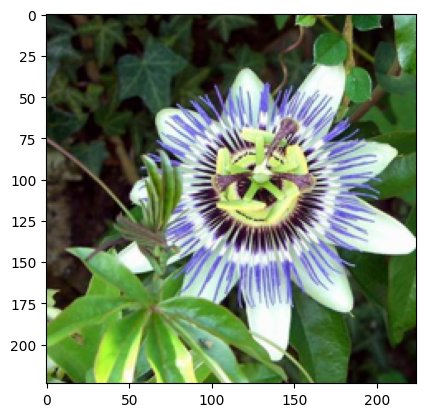

In [42]:
image_path = "./dataset/flower_data/test/image_00005.jpg"
img = process_image(image_path)
imshow(img)

In [43]:
img.shape

(3, 224, 224)

In [45]:
dataiter = iter(dataloaders["valid"])
images, labels = next(dataiter)

model_ft.eval()
if train_on_mps:
  output = model_ft(images.to(device).float())
else:
  output = model_ft(images)

In [46]:
output.shape

torch.Size([8, 102])

In [47]:
_, pred_tensor = torch.max(output, 1)

preds = np.squeeze(pred_tensor.numpy()) \
  if not train_on_mps else np.squeeze(pred_tensor.cpu().numpy())

preds

array([13, 23, 58, 11, 53, 76, 75, 43])

In [49]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    # move channel from axis 0 to axis 2
    image = image.transpose(1, 2, 0)
    # unnormalize
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    #
    image = image.clip(0, 1)

    return image

In [48]:
import json

with open("./dataset/flower_data/cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

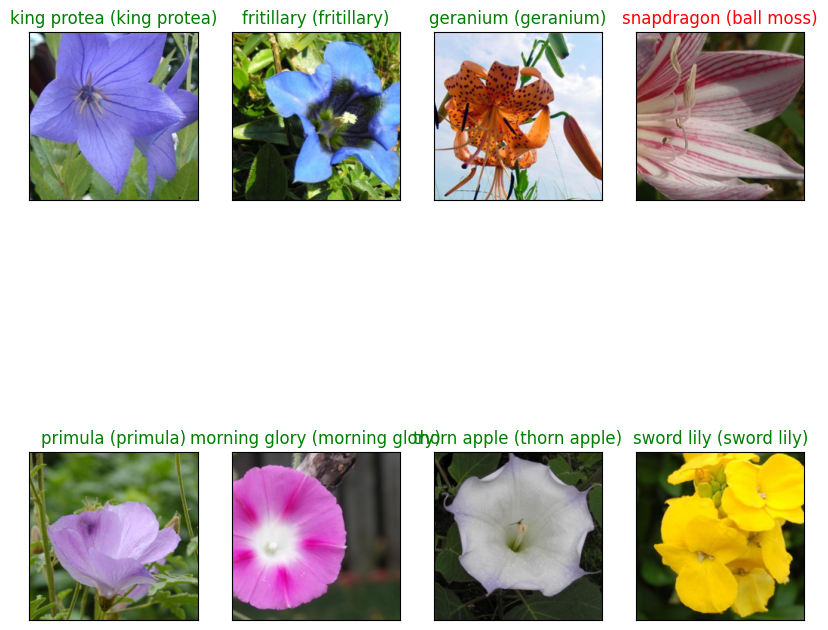

In [51]:
# 展示结果

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 2

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(
        cat_to_name[str(preds[idx])],
        cat_to_name[str(labels[idx].item())]
    ),
        color=("green" if preds[idx] == labels[idx] else "red")
    )

plt.show()